<a href="https://colab.research.google.com/github/NadiaHolmlund/Thesis/blob/main/Thesis_fors%C3%B8g_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📦 **Packages**

In [ ]:
%%capture
# DataMapPlot
!git clone https://github.com/TutteInstitute/datamapplot.git
!pip install datamapplot/.

# GPU-accelerated HDBSCAN + UMAP
#!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
#!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
#!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
#!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

!pip install umap
!pip install hdbscan

# OpenAI
!pip install openai

# Topic Modelling
!pip install bertopic datasets
!pip install sentence-transformers

# Progress bar
!pip install tqdm

# 📄 **Data**

In [ ]:
import textwrap
import pandas as pd

# Import cleaned and processed data
dataset = pd.read_csv('dataset_cleaned.csv')

In [ ]:
import textwrap
import pandas as pd

# Import raw data
berlingske = pd.read_csv('https://raw.githubusercontent.com/NadiaHolmlund/Thesis/main/raw_article_Berlingske_2024-03-04.csv')
jyllands_posten = pd.read_csv('https://raw.githubusercontent.com/NadiaHolmlund/Thesis/main/raw_article_Jyllands_Posten_2024-03-04.csv')
politiken = pd.read_csv('https://raw.githubusercontent.com/NadiaHolmlund/Thesis/main/raw_article_Politiken_2024-03-04.csv')

# Merge the datasets
dataset = pd.concat([berlingske, jyllands_posten, politiken], ignore_index=True)

## Simple Pre-Processing

In [ ]:
# Removing rows with NaN values in the Article column
dataset = dataset.dropna(subset=['Article'])

# Reset the index
dataset.reset_index(drop=True, inplace=True)

In [ ]:
# Merging 'Brief' and 'Article' into one column 'Content'
dataset['Content'] = dataset.apply(lambda row: str(row['Article']) if pd.isna(row['Brief']) else str(row['Brief']) + " " + str(row['Article']), axis=1)

In [ ]:
#import nltk
#from collections import Counter

# Identifying boilerplate content, repetitive footers and headers, subscriptions details etc.

# Tokenize sentences using NLTK
#nltk.download('punkt')
#sentences = nltk.sent_tokenize(" ".join(dataset['Content']))

# Filter out sentences with less than three words
#sentences = [sentence for sentence in sentences if len(nltk.word_tokenize(sentence)) >= 3]

# Count occurrences of each sentence
#sentence_counts = Counter(sentences)

# Sort sentences by occurrence
#sorted_sentences = sorted(sentence_counts.items(), key=lambda x: x[1], reverse=True)

# Print sorted sentences with minimum count of 5 observations
#for sentence, count in sorted_sentences:
#    if count >= 5:
#        print(f"{count} counts: {sentence}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


9875 counts: Jeg bekræfter desuden, at jeg er over 13 år, og at Berlingske Media A/S må opsamle og behandle de anførte personoplysninger til det ovennævnte formål.
9875 counts: Oplysningerne kan indeholde annoncer fra tredjepart og i visse tilfælde blive delt med disse.
4934 counts: I voresprivatlivspolitikkan De læse mere om tredjeparter og hvordan De trækker Deres samtykke tilbage.Ja tak
Tilmeld dig dagens overblik og få de vigtigste historier direkte i din indbakke.
4934 counts: Hermed giver jeg tilladelse til, at Weekendavisen sender en mail med udvalgte historier to gange om ugen og i tilfælde af særlige historier og ekstraordinære begivenheder mere.
4932 counts: I voresprivatlivspolitikkan De læse mere om tredjeparter og hvordan De trækker Deres samtykke tilbage.
1660 counts: Læs mere om fordelene ved et abonnementher.
1460 counts: Som abonnent kan du ubegrænset dele artikler med dine venner og familie.
1213 counts: Der skete enfejl, prøv igen senere eller søg hjælp via voreskund

In [ ]:
dataset.head()

,Date,Source,Search term,URL,Title,Brief,Article,Content,Content_wo_boilerplate
0,2024-02-29,Berlingske,Kunstig intelligens,https://berlingske.dk/politik/ekspertgruppe-vi...,Ekspertgruppe vil have chatbots slået fra som ...,"I rapporten betoner eksperterne, at der er et ...",På flere sociale medier er der chatbots indbyg...,"I rapporten betoner eksperterne, at der er et ...","I rapporten betoner eksperterne, at der er et ..."
1,2024-02-29,Berlingske,Kunstig intelligens,https://berlingske.dk/politik/fakta-ekspertgru...,FAKTA: Ekspertgruppe vil have AI-indhold dekla...,af kunstig intelligens.,En ekspertgruppe nedsat af regeringen har tors...,af kunstig intelligens. En ekspertgruppe nedsa...,af kunstig intelligens. En ekspertgruppe nedsa...
2,2024-02-29,Berlingske,Kunstig intelligens,https://berlingske.dk/virksomheder/ekspertgrup...,Ekspertgruppe slår alarm: Nu skal der hegnspæl...,»Hvis kunstig intelligens skal bidrage positiv...,Bekymringen for skadevirkningerne af kunstig i...,»Hvis kunstig intelligens skal bidrage positiv...,»Hvis kunstig intelligens skal bidrage positiv...
3,2024-02-29,Berlingske,Kunstig intelligens,https://berlingske.dk/politik/opfordring-til-b...,Opfordring til boykot har gjort DF-spids rasen...,NaN,"Godmorgen, kære læser, og velkommen til Berlin...","Godmorgen, kære læser, og velkommen til Berlin...","Godmorgen, kære læser, og velkommen til Berlin..."
4,2024-02-29,Berlingske,Kunstig intelligens,https://berlingske.dk/business/business-overbl...,Business-overblik: Bankernes overskud har aldr...,NaN,Godmorgen og velkommen til torsdagens Business...,Godmorgen og velkommen til torsdagens Business...,Godmorgen og velkommen til torsdagens Business...


In [ ]:
# Example view of title and content
print(textwrap.fill(dataset['Title'][7050], width=140))
print(textwrap.fill(dataset['Content'][7050], width=140))

Dansk intelligent hjertealarm skal redde liv
Danske forskere udvikler en alarm, der kan forudsige hjerteanfald hos personer med avancerede pacemakere. Der er ikke oplæsning af denne
artikel, så den oplæses derfor med maskinstemme. Kontakt os gerne påautomatiskoplaesning@pol.dk, hvis du hører ord, hvis udtale kan
forbedres. Indtil nu har danske hjertelæger selv skullet analysere tusindvis af signaler og sendinger fra pacemakere og andre hjerteenheder
landet over, og dermed vurdere om patienten har brug for hjælp. Men en ny intelligent hjertealarm skal i fremtiden give lægerne en hjælpende
hånd. Den danskudviklede hjertealarm, der potentielt kan redde menneskeliv, bliver i øjeblikket testet af lægerne på Rigshospitalet. Tariq
Andersen, der er adjunkt på Datalogisk Institut på Københavns Universitet, er med til at teste alarmen. » Alarmen består af en algoritme,
der kigger på data fra folks hjerteenheder. Den kigger så på det data og laver en forudsigelse af, hvad risikoen er for et hjert

In [ ]:
len(dataset['Content'])

7804

# 💬 **Utilizing OpenAI and Together.ai API**

In [ ]:
from google.colab import userdata

In [ ]:
from openai import OpenAI

In [ ]:
TOGETHER_API_KEY = userdata.get('TOGETHER_API_KEY')

In [ ]:
client = OpenAI(base_url="https://api.together.xyz/v1", api_key=TOGETHER_API_KEY)

In [ ]:
# Testing that the model is loaded correctly by running a prompt
system = "You are a helpful assistant"
user = "Explain artificial intelligence as if I am 5?"

In [ ]:
completion = client.chat.completions.create(
  model="NousResearch/Nous-Hermes-2-Mistral-7B-DPO",
  messages=[
    {"role": "system", "content": system},
    {"role": "user", "content": user}
  ],
  temperature=0.2,
)

In [ ]:
print(textwrap.fill(completion.choices[0].message.content, width=140))

Alright, imagine you have a toy robot named AI Robby. AI stands for Artificial Intelligence. Now, Robby can learn and do things on its own,
just like you and me! When you teach Robby something new, like how to play catch, it gets better at it each time you practice. That's
because Robby's brain is like a computer that gets smarter as it learns. So, AI Robby can help you with tasks, play games, and even tell you
funny jokes!


## **Prompt Engineering for Translation and Data Cleaning**

In [ ]:
from tqdm import tqdm

# Initialize progress bar
pbar = tqdm(total=len(dataset))

  0%|          | 0/5 [00:00<?, ?it/s]

### **Translating Titles**

In [ ]:
# Translating article titles to English

# Iterate over dataset rows
for index, row in dataset.iterrows():
    # Access title content from the 'Title' column
    title_content = row['Title']

    # Define the system and user messages
    system = "You are a helpful, respectful and honest assistant specialized in translating text data from Danish to English."
    user = "Translate the following text from Danish to English:\n\n" + title_content

    # Create completion using Together.ai API and Mistral
    completion = client.chat.completions.create(
        model="NousResearch/Nous-Hermes-2-Mistral-7B-DPO",
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": user}
        ],
        temperature=0.2
    )

    # Get cleaned text from completion
    translated_title = textwrap.fill(completion.choices[0].message.content, width=100)

    # Add cleaned text to new column 'Article_cleaned'
    dataset.at[index, 'Title_translated'] = translated_title

    # Update progress bar
    pbar.update(1)

# Close progress bar
pbar.close()

In [ ]:
dataset[['Title', 'Title_translated']].head(20)

,Title,Title_translated
0,Ekspertgruppe vil have chatbots slået fra som ...,The expert group wants chatbots to be turned o...
1,FAKTA: Ekspertgruppe vil have AI-indhold dekla...,FACTS: Expert group wants AI content declared
2,Ekspertgruppe slår alarm: Nu skal der hegnspæl...,Expert group raises alarm: Now there should be...
3,Opfordring til boykot har gjort DF-spids rasen...,Invitation to boycott has made DF leader furio...
4,Business-overblik: Bankernes overskud har aldr...,Business Overview: Banks' surpluses have never...
5,Berlingske bad Googles kritiserede chatbot om ...,Berlingske asked Google's criticized chatbot t...
6,Jeg bad Googles nye kunstige intelligens om at...,I asked Google's new artificial intelligence t...
7,"Apple trækker stikket på sin hemmelige, selvkø...","Apple pulls the plug on its secret, self-drivi..."
8,Business-overblik: Pensionskunder går glip af ...,Business Overview: Pension customers miss out ...
9,Elon Musk håner Apples beslutning om at skrott...,Elon Musk criticizes Apple's decision to scrap...


### **Translating and Cleaning Content**

In [ ]:
# Translating the Content column and cleaning the translated content


# Iterate over dataset rows
for index, row in dataset.iterrows():
    # Access content from the 'Content' column
    article_content = row['Content']

    # Define the system and user messages for translation
    translation_system = "You are a helpful, respectful and honest assistant specialized in translating text data from Danish to English."
    translation_user = "Translate the following text from Danish to English:\n\n" + article_content

    # Create completion for translation using Together.ai API and Mistral
    translation_completion = client.chat.completions.create(
        model="NousResearch/Nous-Hermes-2-Mistral-7B-DPO",
        messages=[
            {"role": "system", "content": translation_system},
            {"role": "user", "content": translation_user}
        ],
        temperature=0.2
    )

    # Get translated text
    translated_content = translation_completion.choices[0].message.content

    # Add translated text to new column 'Content_translated'
    dataset.at[index, 'Content_translated'] = translated_content

    # Define the system and user messages for cleaning
    cleaning_system = "You are a helpful, respectful and honest assistant specialized in cleaning text data"
    cleaning_user = "Clean the following text. Keep only the core content and remove irrelevent information:\n\n" + translated_content

    # Create completion for cleaning using Together.ai API and Mistral
    cleaning_completion = client.chat.completions.create(
        model="NousResearch/Nous-Hermes-2-Mistral-7B-DPO",
        messages=[
            {"role": "system", "content": cleaning_system},
            {"role": "user", "content": cleaning_user}
        ],
        temperature=0.2
    )

    # Get cleaned text
    cleaned_content = cleaning_completion.choices[0].message.content

    # Add cleaned text to new column 'Content_cleaned'
    dataset.at[index, 'Content_cleaned'] = cleaned_content

    # Update progress bar
    pbar.update(1)

# Close progress bar
pbar.close()

In [ ]:
dataset[['Content', 'Content_translated', 'Content_cleaned']].head()

,Content,Content_translated,Content_cleaned
6000,Systemet bruger kunstig intelligens til at lær...,The system uses artificial intelligence to lea...,The system uses artificial intelligence to lea...
6001,I stedet er selskabet i gang med at genopfinde...,"In place of this, the company is in the proces...",The company is reinventing itself with a focus...
6002,øget samarbejde med politiet rundt om i landet...,Increased cooperation with police forces acros...,"Nets, Danske Bank, and Copenhagen Police are c..."
6003,"I princippet, ja,« siger Thomas Bolander, der ...","In principle, yes,« says Thomas Bolander, who ...",Elon Musk and tech billionaires believe we liv...
6004,Siden har hun arbejdet meget med cirkulær økon...,"Since then, she has worked a lot with circular...","Since then, she has worked a lot with circular..."


In [ ]:
# Saving the cleaned dataset as csv
dataset.to_csv('dataset_cleaned.csv', index=False)

In [ ]:
from datasets import Dataset

# Create a dictionary instead of a pandas dataframe
data_dict = {
    "Content_cleaned": dataset["Content_cleaned"].tolist(),
    "Title_translated": dataset["Title_translated"].tolist()
}

# Create a dataset object
dataset_dict = Dataset.from_dict(data_dict)

# Extract cleaned content to train on and corresponding titles
content = dataset_dict["Content_cleaned"]
titles = dataset_dict["Title_translated"]

## **Promt Engineering for Topic Labelling**

### **Prompt Template**



In [ ]:
# System prompt describes information given to all conversations
system_prompt = """
You are a helpful, respectful and honest assistant specialized in labeling topics of news articles.
"""

In [ ]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
"""

example_output = """Environmental impacts of eating meat"""

In [ ]:
# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
"""

In [ ]:
prompt = system_prompt + example_prompt + example_output + main_prompt

In [ ]:
print(prompt)


You are a helpful, respectful and honest assistant specialized in labeling topics of news articles.

I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
Environmental impacts of eating meat
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic

# 🗨️  **BERTopic**

## **Preparing Embeddings**

In [ ]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(content, show_progress_bar=True)

Batches:   0%|          | 0/244 [00:00<?, ?it/s]

## **Sub-models**

In [ ]:
#from cuml.manifold import UMAP
#from cuml.cluster import HDBSCAN
from umap import UMAP
from hdbscan import HDBSCAN

#umap_model = UMAP(n_neighbors=3, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
#hdbscan_model = HDBSCAN(min_cluster_size=25, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# best params so far: n_neigbors=5 og min_cluster=30

# UMAP parameters
umap_model = UMAP(n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# HDBSCAN parameters
hdbscan_model = HDBSCAN(min_cluster_size=30, metric='euclidean', cluster_selection_method='eom', prediction_data=True)


In [ ]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

### **Representation Models**

In [ ]:
prompt = """
I have a topic that is described by the following keywords: [KEYWORDS]
In this topic, the following documents are a small but representative subset of all documents in the topic:
[DOCUMENTS]

Based on the information above, please give a topic label of maximum 6 words:
topic: <label>
"""

In [ ]:
from bertopic.representation import OpenAI

from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

openai_rep = OpenAI(client, model="NousResearch/Nous-Hermes-2-Mistral-7B-DPO",
                    chat=True,
                    prompt=prompt,
                    nr_docs=7,
                    delay_in_seconds=3)


# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Mixtral": openai_rep,
    "MMR": mmr,
}

# 🔥 **Training**

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=15,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(content, embeddings)

2024-03-30 08:17:41,720 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-30 08:18:01,638 - BERTopic - Dimensionality - Completed ✓
2024-03-30 08:18:01,641 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-30 08:18:02,093 - BERTopic - Cluster - Completed ✓
2024-03-30 08:18:02,102 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 50/50 [02:50<00:00,  3.42s/it]
2024-03-30 08:22:58,498 - BERTopic - Representation - Completed ✓


In [ ]:
# e.g. add this in method - have to reduce the articles

# BadRequestError: Error code: 400 - {'error': {'message': 'Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 10345 `inputs` tokens and 1 `max_new_tokens`', 'type': 'invalid_request_error', 'param': 'max_tokens', 'code': None}}

In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Mixtral,MMR,Representative_Docs
0,-1,3259,-1_the_and_to_of,"[the, and, to, of, in, is, for, that, with, on...","[technology, ai, intelligence, future, robots,...",[Artificial Intelligence & Workplace Transform...,"[and, to, of, in, for, with, it, as, has, inte...",[The core content of the text is about the con...
1,0,382,0_bank_the_in_of,"[bank, the, in, of, to, and, danish, company, ...","[investors, business, entrepreneurs, investmen...","[Banking, Danish Companies, Financial Markets]","[bank, the, in, to, danish, company, has, year...",[Can 14 employees at the Financial Intelligenc...
2,1,318,1_facebook_zuckerberg_users_content,"[facebook, zuckerberg, users, content, media, ...","[zuckerberg, facebook, instagram, twitter, soc...",[Social Media Platforms Growth and Investments],"[facebook, zuckerberg, users, content, media, ...","[Last year's mobile game phenomenon, Pokémon G..."
3,2,222,2_chatgpt_chatbot_intelligence_openai,"[chatgpt, chatbot, intelligence, openai, artif...","[chatbots, chatgpt, chatbot, openai, ai, intel...",[ChatGPT and Bard: AI Chatbots and Regulation],"[chatgpt, chatbot, intelligence, openai, ai, b...",[The answers are generated and written by arti...
4,3,217,3_party_the_in_is,"[party, the, in, is, and, of, that, to, it, mi...","[denmark, political, politicians, danish, fred...",[Party Politics and Burka Ban in Denmark],"[party, in, is, and, it, minister, not, has, a...","[Well, but ...\nIf one is to understand what h..."
5,4,197,4_digital_digitalization_denmark_companies,"[digital, digitalization, denmark, companies, ...","[denmark, digitalization, technology, innovati...",[Digitalization and AI in Danish Companies],"[digital, digitalization, denmark, companies, ...",[Denmark is committed to the new digital reali...
6,5,183,5_healthcare_patients_treatment_cancer,"[healthcare, patients, treatment, cancer, syst...","[healthcare, patients, medicine, medical, rese...",[AI in Danish Healthcare],"[healthcare, patients, treatment, cancer, syst...",[New documentation systems and advanced robot ...
7,6,158,6_china_us_trump_president,"[china, us, trump, president, the, chinese, an...","[china, vietnam, jinping, global, superpower, ...",[China-US Trade Tensions and Geopolitical Conf...,"[china, us, trump, president, trade, donald, w...","[""Made in China 2025"" aims to make China the w..."
8,7,156,7_stories_parties_third_consent,"[stories, parties, third, consent, information...","[weekendavisen, berlingske, media, news, conse...","[AI, privacy, newsletters, consent, Weekendavi...","[stories, parties, third, consent, information...","[OpenAI's groundbreaking chatbot, ChatGPT, has..."
9,8,148,8_jobs_will_robots_and,"[jobs, will, robots, and, artificial, intellig...","[robots, innovation, ai, technology, digitaliz...",[Robots and AI: Job Transformation],"[jobs, will, robots, and, artificial, intellig...",[New jobs taken by robots: Many jobs in relate...


In [ ]:
topic_model.get_topic(1, full=True)["KeyBERT"]

[('zuckerberg', 0.8893468),
 ('facebook', 0.8892342),
 ('instagram', 0.8420846),
 ('twitter', 0.83591723),
 ('social', 0.8296886),
 ('news', 0.81931543),
 ('media', 0.8097694),
 ('users', 0.80723596),
 ('billion', 0.807154),
 ('youtube', 0.80576515)]

In [ ]:
mixtral_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Mixtral"].values()]
topic_model.set_topic_labels(mixtral_labels)

# 📊 **Visualize**

In [ ]:
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

In [ ]:
import PIL
import numpy as np
import requests

# Prepare logo
bertopic_logo_response = requests.get(
    "https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png",
    stream=True,
    headers={'User-Agent': 'My User Agent 1.0'}
)
bertopic_logo = np.asarray(PIL.Image.open(bertopic_logo_response.raw))

NameError: name 'plot' is not defined

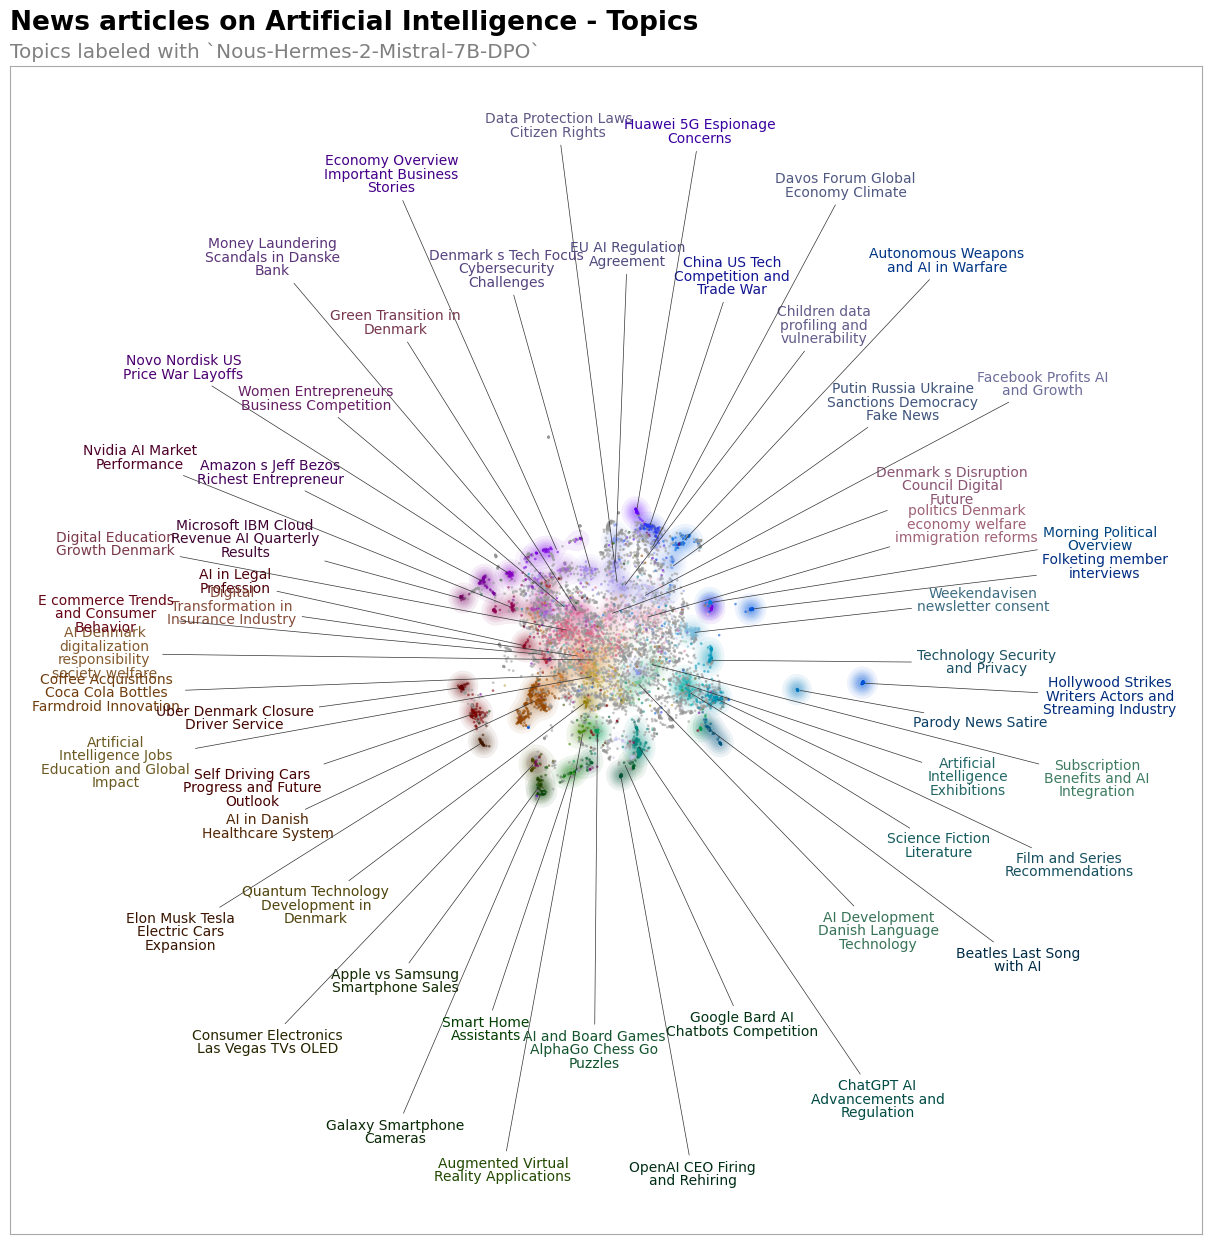

In [ ]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["Mixtral"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=10,
    title="News articles on Artificial Intelligence - Topics",
    sub_title="Topics labeled with `Nous-Hermes-2-Mistral-7B-DPO`",
    label_wrap_width=20,
    use_medoids=True,
    #logo=bertopic_logo,
    #logo_width=0.16
)

In [ ]:
#dataset.to_parquet('articles_with_tm.pq')